In [3]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Compose, Resize, ToTensor
from torch.optim import lr_scheduler

In [4]:
class Stanford40Dataset(Dataset):
    def __init__(self, img_dir, split_file, transform=None):
        self.img_dir = img_dir
        with open(split_file, 'r') as file:
            self.img_list = file.readlines()
        self.transform = transform
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img_name = self.img_list[idx].rstrip('\n')
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')  # Ensure image is RGB
        label = img_name.split('_')[0]  # Extract action name from file name
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transformations
transform = Compose([
    Resize((256, 256)),
    ToTensor()
])

# Paths to the directories and split files
img_dir = '/Users/mwr/Downloads/AVPR assignment 2/Stanford40/JPEGImages'
train_split_file = '/Users/mwr/Downloads/AVPR assignment 2/Stanford40/ImageSplits/train.txt'
test_split_file = '/Users/mwr/Downloads/AVPR assignment 2/Stanford40/ImageSplits/test.txt'

# Create the dataset
train_dataset = Stanford40Dataset(img_dir=img_dir, split_file=train_split_file, transform=transform)
test_dataset = Stanford40Dataset(img_dir=img_dir, split_file=test_split_file, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# Example to get one batch of data
for images, labels in train_loader:
    # Here images is a batch of images and labels is a batch of corresponding labels
    print(images.shape, labels)
    break  # Remove this break to iterate over the whole dataset

torch.Size([32, 3, 256, 256]) ('pouring', 'playing', 'rowing', 'watching', 'pushing', 'blowing', 'phoning', 'looking', 'playing', 'walking', 'smoking', 'playing', 'jumping', 'waving', 'pouring', 'using', 'pushing', 'playing', 'phoning', 'running', 'jumping', 'using', 'writing', 'writing', 'pushing', 'applauding', 'washing', 'playing', 'playing', 'throwing', 'fixing', 'riding')


In [43]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.optim import lr_scheduler

# Dataset class for Stanford 40
class Stanford40Dataset(Dataset):
    def __init__(self, img_dir, split_file, transform=None, label_dict=None):
        self.img_dir = img_dir
        with open(split_file, 'r') as file:
            self.img_list = file.readlines()
        self.transform = transform
        self.label_dict = label_dict

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = self.img_list[idx].rstrip('\n')
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.label_dict[img_name.split('_')[0]]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

# Enhanced Transform with Augmentations
transform = Compose([
    Resize((256, 256)), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    ToTensor(), 
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Paths and dataset loaders
img_dir = '/Users/mwr/Downloads/AVPR assignment 2/Stanford40/JPEGImages'
train_split_file = '/Users/mwr/Downloads/AVPR assignment 2/Stanford40/ImageSplits/train.txt'
test_split_file = '/Users/mwr/Downloads/AVPR assignment 2/Stanford40/ImageSplits/test.txt'
unique_labels = sorted(set([line.split('_')[0] for line in open(train_split_file, 'r')]))
label_dict = {label: idx for idx, label in enumerate(unique_labels)}

train_dataset = Stanford40Dataset(img_dir, train_split_file, transform=transform, label_dict=label_dict)
test_dataset = Stanford40Dataset(img_dir, test_split_file, transform=transform, label_dict=label_dict)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class EnhancedCNN(nn.Module):
    def __init__(self, num_classes=40, activation='tanh'):
        super(EnhancedCNN, self).__init__()
        # Define layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
        
        # Activation function selection
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'tanh':
            self.activation = nn.Tanh()

    def forward(self, x):
        x = self.pool(self.activation(self.bn1(self.conv1(x))))
        x = self.pool(self.activation(self.bn2(self.conv2(x))))
        x = self.pool(self.activation(self.bn3(self.conv3(x))))
        x = self.global_pool(x)
        x = x.view(-1, 128)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
# Validation function
def validate(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model and move it to the device
model = EnhancedCNN(num_classes=40, activation='tanh').to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer with the learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.05)

# Specify the number of epochs 
num_epochs = 5  

# Initialize the best validation accuracy variable
best_acc = 0.0

# Training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()
    
    # Iterate over the training set
    for images, labels in train_loader:
        # Transfer images and labels to your device
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Calculate the loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
    # Adjust the learning rate based on the scheduler
    scheduler.step()
    
    # Validation step after each epoch
    val_acc = validate(model, test_loader)
    print(f'Epoch {epoch+1}: Validation Accuracy: {val_acc}%')
    
    # Check if the validation accuracy is the best and save the model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

# Test function
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Test the model after training
test_accuracy = test_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy}%')

# Save test results to a file
with open('test_accuracy.txt', 'w') as file:
    file.write(f'Test Accuracy: {test_accuracy}%\n')

Epoch 1: Validation Accuracy: 11.171366594360087%
Epoch 2: Validation Accuracy: 11.478669558929862%
Epoch 3: Validation Accuracy: 12.79826464208243%
Epoch 4: Validation Accuracy: 13.322487346348518%
Epoch 5: Validation Accuracy: 13.376717281272596%
Test Accuracy: 13.250180766449747%


In [47]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.optim import lr_scheduler
import copy

# Dataset class for Stanford 40
class Stanford40Dataset(Dataset):
    def __init__(self, img_dir, split_file, transform=None, label_dict=None):
        self.img_dir = img_dir
        with open(split_file, 'r') as file:
            self.img_list = file.readlines()
        self.transform = transform
        self.label_dict = label_dict

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = self.img_list[idx].rstrip('\n')
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.label_dict[img_name.split('_')[0]]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

# Enhanced Transform with Augmentations
transform = Compose([
    Resize((256, 256)), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    ToTensor(), 
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Paths and dataset loaders
img_dir = '/Users/mwr/Downloads/AVPR assignment 2/Stanford40/JPEGImages'
train_split_file = '/Users/mwr/Downloads/AVPR assignment 2/Stanford40/ImageSplits/train.txt'
test_split_file = '/Users/mwr/Downloads/AVPR assignment 2/Stanford40/ImageSplits/test.txt'
unique_labels = sorted(set([line.split('_')[0] for line in open(train_split_file, 'r')]))
label_dict = {label: idx for idx, label in enumerate(unique_labels)}


train_dataset = Stanford40Dataset(img_dir, train_split_file, transform=transform, label_dict=label_dict)
test_dataset = Stanford40Dataset(img_dir, test_split_file, transform=transform, label_dict=label_dict)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

resnet_model = models.resnet18(pretrained=True)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 40)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet_model.parameters(), lr=0.0001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

def validate(model, val_loader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return val_loss / len(val_loader), 100 * correct / total


best_model_wts = copy.deepcopy(resnet_model.state_dict())
best_acc = 0.0
early_stopping_patience = 5
no_improvement_epochs = 0

num_epochs = 10  # Set  number of epochs

for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)

    val_loss, val_acc = validate(resnet_model, test_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
    scheduler.step(val_loss)

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(resnet_model.state_dict())
        torch.save(resnet_model.state_dict(), 'resnet_best_model.pth')
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1
        if no_improvement_epochs >= early_stopping_patience:
            print("Early stopping triggered")
            break

resnet_model.load_state_dict(best_model_wts)


# Test function
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy


test_accuracy = test_model(resnet_model, test_loader)
with open('resnet_test_results.txt', 'w') as file:
    file.write(f'Test Accuracy: {test_accuracy}%\n')


Epoch 1/10, Training Loss: 2.2729, Validation Loss: 1.4564, Validation Accuracy: 62.04%
Epoch 2/10, Training Loss: 1.1292, Validation Loss: 1.1175, Validation Accuracy: 69.49%
Epoch 3/10, Training Loss: 0.7161, Validation Loss: 0.9579, Validation Accuracy: 74.02%
Epoch 4/10, Training Loss: 0.4511, Validation Loss: 0.9354, Validation Accuracy: 73.93%
Epoch 5/10, Training Loss: 0.2859, Validation Loss: 0.8778, Validation Accuracy: 75.23%
Epoch 6/10, Training Loss: 0.1784, Validation Loss: 0.8959, Validation Accuracy: 74.48%
Epoch 7/10, Training Loss: 0.1172, Validation Loss: 0.8805, Validation Accuracy: 74.96%
Epoch 8/10, Training Loss: 0.0799, Validation Loss: 0.8438, Validation Accuracy: 75.94%
Epoch 9/10, Training Loss: 0.0597, Validation Loss: 0.8669, Validation Accuracy: 75.23%
Epoch 10/10, Training Loss: 0.0422, Validation Loss: 0.8206, Validation Accuracy: 76.48%


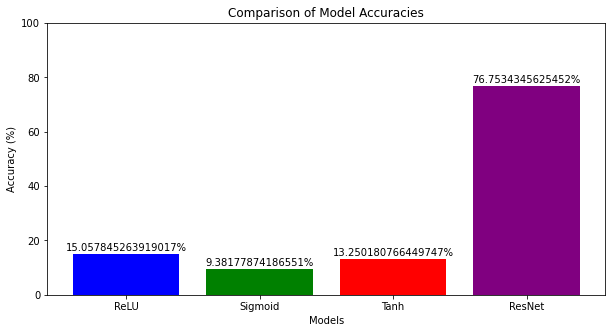

In [50]:
import matplotlib.pyplot as plt

# Function to read accuracy from text file
def read_accuracy(file_path):
    with open(file_path, 'r') as file:
        accuracy = file.readline().strip()
        try:
            return float(accuracy.split(': ')[1].replace('%', ''))
        except ValueError:
            return None

# Paths to your accuracy text files
relu_accuracy_file = '/Users/mwr/Downloads/AVPR assignment 2/relu_test_accuracy.txt'
sigmoid_accuracy_file = '/Users/mwr/Downloads/AVPR assignment 2/sigmoid_test_accuracy.txt'
tanh_accuracy_file = '/Users/mwr/Downloads/AVPR assignment 2/tanh_test_accuracy.txt'
resnet_accuracy_file = '/Users/mwr/Downloads/AVPR assignment 2/resnet_test_accuracy.txt'

# Reading accuracies
relu_accuracy = read_accuracy(relu_accuracy_file)
sigmoid_accuracy = read_accuracy(sigmoid_accuracy_file)
tanh_accuracy = read_accuracy(tanh_accuracy_file)
resnet_accuracy = read_accuracy(resnet_accuracy_file)

# Plotting accuracies
models = ['ReLU', 'Sigmoid', 'Tanh', 'ResNet']
accuracies = [relu_accuracy, sigmoid_accuracy, tanh_accuracy, resnet_accuracy]

plt.figure(figsize=(10, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracies')
plt.ylim([0, 100])  # Assuming accuracy percentages
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.5, f"{v}%", ha='center', va='bottom')
plt.show()
